# Explain PyTextRank: the algorithm

Let's look at the *TextRank* algorithm used to build a graph from a raw text, and then from that extract the top-ranked phrases. This work is based on 
["TextRank: Bringing Order into Text"](http://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf),
Rada Mihalcea, Paul Tarau, _Empirical Methods in Natural Language Processing_ (2004).

---
First we perform some basic housekeeping for Jupyter, then load `spaCy` with a language model for English ...

In [1]:
!conda install -y matplotlib

/opt/homebrew/bin/bash: line 1: conda: command not found


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#!python -m spacy download en_core_web_md 

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_md-3.5.0/en_core_web_md-3.5.0-py3-none-any.whl (42.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [1]:
import spacy
nlp = spacy.load("en_core_web_sm")

Now, to get started, we'll create some text to use.

In [2]:
text = """
Defence and security are on the agenda when Anthony Albanese and Narendra Modi meet for their annual leaders' summit in New Delhi. Anthony Albanese is seen in the cockpit of a fighter jet during his visit to inspect the INS Vikrant in Mumbai. Anthony Albanese climbed into the cockpit of a fighter jet during his visit to inspect the INS Vikrant in Mumbai. Source: Twitter / @indiannavy Crucial trade talks with Prime Minister Narendra Modi will be the focus of Anthony Albanese's third day in India, where Australia seeks to reap the benefits of the Asian nation's decarbonisation. The pair will meet for their annual leaders' summit in New Delhi on Friday, with renewable energy and technology to feature on the agenda along with defence and security. Talks got off to a triumphant start on Thursday when the leaders were met by raucous applause while being given a lap of honour before the fourth Border-Gavaskar cricket Test in Ahmedabad. Advertisement READ MORE Anthony Albanese to hold talks with Joe Biden and Rishi Sunak on AUKUS defence pact Mr Albanese said India is a "top-tier security partner" for Australia during an inspection of India's first domestically built aircraft carrier, the INS Vikrant, in Mumbai. He met with naval personnel before climbing into the cockpit of an Indian light fighter jet. He also used the visit to confirm Australia will host Exercise Malabar for the first time later this year. Prime Minister Albanese's attention now turns to securing Australia a bigger role in helping India slash its carbon emissions in the coming years. India has set ambitious goals of 50 per cent renewable energy and 30 per cent electric vehicle usage by 2030. Trade Minister Don Farrell, who's leading a business delegation on the trip, said Australia could help India as it goes green. READ MORE Human rights issues loom over Anthony Albanese's trip to India "We are talking both about supplying our traditional fossil fuels but also India is very committed to decarbonisation," he said. "We have great prospects of expanding our role in that decarbonisation process that's going on in India. "They're very interested in our critical minerals but they're also interested in the supply of hydrogen which of course will take the place of gas as we transition to a decarbonised economy." Mr Farrell said a free trade deal between the two nations was already bearing fruit, with more than $2.5 billion worth of Australian produce hitting India. Anthony Albanese promotes new higher education partnership with India 09 Mar 2023, 7:27 pm Anthony Albanese promotes new higher education partnership with India India and Australia are also expected to sign an agreement to bring their film industries closer together. "For me, films are food for the soul ... they tell stories, help us to feel, and reflect who we are and where we come from," Mr Albanese said. "I look forward to seeing more Indian-Australian co-productions on our screens showcasing the best of both our cultures, landscapes and people." He will also address the Indian Institute of Technology about opportunities to strengthen higher education links, holding a question and answer session with students.
"""
doc = nlp(text)

In [3]:
doc


Defence and security are on the agenda when Anthony Albanese and Narendra Modi meet for their annual leaders' summit in New Delhi. Anthony Albanese is seen in the cockpit of a fighter jet during his visit to inspect the INS Vikrant in Mumbai. Anthony Albanese climbed into the cockpit of a fighter jet during his visit to inspect the INS Vikrant in Mumbai. Source: Twitter / @indiannavy Crucial trade talks with Prime Minister Narendra Modi will be the focus of Anthony Albanese's third day in India, where Australia seeks to reap the benefits of the Asian nation's decarbonisation. The pair will meet for their annual leaders' summit in New Delhi on Friday, with renewable energy and technology to feature on the agenda along with defence and security. Talks got off to a triumphant start on Thursday when the leaders were met by raucous applause while being given a lap of honour before the fourth Border-Gavaskar cricket Test in Ahmedabad. Advertisement READ MORE Anthony Albanese to hold talks w

How many sentences are in the parsed document and where are their boundaries?

In [4]:
for sent in doc.sents:
    print(">", sent.start, sent.end)
    print(sent)

> 0 25

Defence and security are on the agenda when Anthony Albanese and Narendra Modi meet for their annual leaders' summit in New Delhi.
> 25 47
Anthony Albanese is seen in the cockpit of a fighter jet during his visit to inspect the INS Vikrant in Mumbai.
> 47 68
Anthony Albanese climbed into the cockpit of a fighter jet during his visit to inspect the INS Vikrant in Mumbai.
> 68 108
Source: Twitter / @indiannavy Crucial trade talks with Prime Minister Narendra Modi will be the focus of Anthony Albanese's third day in India, where Australia seeks to reap the benefits of the Asian nation's decarbonisation.
> 108 140
The pair will meet for their annual leaders' summit in New Delhi on Friday, with renewable energy and technology to feature on the agenda along with defence and security.
> 140 175
Talks got off to a triumphant start on Thursday when the leaders were met by raucous applause while being given a lap of honour before the fourth Border-Gavaskar cricket Test in Ahmedabad.
> 17

What are the raw _noun chunks_ in the parsed document, as well as its _named entities_?

In [5]:
for chunk in doc.noun_chunks:
    print(chunk.text)


Defence
security
the agenda
Anthony Albanese
Narendra Modi
their annual leaders' summit
New Delhi
Anthony Albanese
the cockpit
a fighter jet
his visit
the INS Vikrant
Mumbai
Anthony Albanese
the cockpit
a fighter jet
his visit
the INS Vikrant
Mumbai
Source
Twitter / @indiannavy Crucial trade talks
Prime Minister Narendra Modi
the focus
Anthony Albanese's third day
India
Australia
the benefits
the Asian nation's decarbonisation
The pair
their annual leaders' summit
New Delhi
Friday
renewable energy
technology
the agenda
defence
security
Talks
a triumphant start
Thursday
the leaders
raucous applause
a lap
honour
the fourth Border-Gavaskar cricket Test
Ahmedabad
Advertisement
MORE Anthony Albanese
talks
Joe Biden
Rishi Sunak
AUKUS defence pact
Mr Albanese
India
a "top-tier security partner
Australia
an inspection
India's first domestically built aircraft carrier
the INS Vikrant
Mumbai
He
naval personnel
the cockpit
an Indian light fighter jet
He
the visit
Australia
Exercise Malabar
the f

In [6]:
for ent in doc.ents:
    print(ent.text, ent.label_, ent.start, ent.end)

Anthony Albanese PERSON 9 11
Narendra Modi PERSON 12 14
annual DATE 17 18
New Delhi GPE 22 24
Anthony Albanese PERSON 25 27
Mumbai GPE 45 46
Anthony Albanese PERSON 47 49
Mumbai GPE 66 67
Narendra Modi PERSON 79 81
Anthony Albanese's PERSON 86 89
third day DATE 89 91
India GPE 92 93
Australia GPE 95 96
Asian NORP 103 104
annual DATE 114 115
New Delhi GPE 119 121
Friday DATE 122 123
Thursday DATE 148 149
fourth ORDINAL 166 167
Border-Gavaskar ORG 167 170
Ahmedabad GPE 173 174
Anthony Albanese PERSON 178 180
Joe Biden PERSON 184 186
Rishi PERSON 187 188
Albanese PERSON 194 195
India GPE 196 197
Australia GPE 207 208
India GPE 212 213
first ORDINAL 214 215
the INS Vikrant ORG 220 223
Mumbai GPE 225 226
Indian NORP 239 240
Australia GPE 251 252
Exercise Malabar PRODUCT 254 256
first ORDINAL 258 259
later this year DATE 260 263
Albanese PERSON 266 267
Australia GPE 273 274
India GPE 279 280
the coming years DATE 285 288
India GPE 289 290
50 per cent MONEY 295 298
30 per cent MONEY 301 304
2

In [7]:
for token in doc:
    print("text[{}] lemma[{}] pos[{}] tag[{}] dep[{}] shape[{}] is_alpha[{}] is_stop[{}]".format(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop))

text[
] lemma[
] pos[SPACE] tag[_SP] dep[dep] shape[
] is_alpha[False] is_stop[False]
text[Defence] lemma[Defence] pos[PROPN] tag[NNP] dep[nsubj] shape[Xxxxx] is_alpha[True] is_stop[False]
text[and] lemma[and] pos[CCONJ] tag[CC] dep[cc] shape[xxx] is_alpha[True] is_stop[True]
text[security] lemma[security] pos[NOUN] tag[NN] dep[conj] shape[xxxx] is_alpha[True] is_stop[False]
text[are] lemma[be] pos[AUX] tag[VBP] dep[ROOT] shape[xxx] is_alpha[True] is_stop[True]
text[on] lemma[on] pos[ADP] tag[IN] dep[prep] shape[xx] is_alpha[True] is_stop[True]
text[the] lemma[the] pos[DET] tag[DT] dep[det] shape[xxx] is_alpha[True] is_stop[True]
text[agenda] lemma[agenda] pos[NOUN] tag[NN] dep[pobj] shape[xxxx] is_alpha[True] is_stop[False]
text[when] lemma[when] pos[SCONJ] tag[WRB] dep[advmod] shape[xxxx] is_alpha[True] is_stop[True]
text[Anthony] lemma[Anthony] pos[PROPN] tag[NNP] dep[compound] shape[Xxxxx] is_alpha[True] is_stop[False]
text[Albanese] lemma[Albanese] pos[PROPN] tag[NNP] dep[nsubj] s

In [8]:
for attr in dir(doc):
    print(attr)

_
__bytes__
__class__
__delattr__
__dir__
__doc__
__eq__
__format__
__ge__
__getattribute__
__getitem__
__gt__
__hash__
__init__
__init_subclass__
__iter__
__le__
__len__
__lt__
__ne__
__new__
__pyx_vtable__
__reduce__
__reduce_ex__
__repr__
__setattr__
__setstate__
__sizeof__
__str__
__subclasshook__
__unicode__
_bulk_merge
_context
_get_array_attrs
_realloc
_vector
_vector_norm
cats
char_span
copy
count_by
doc
ents
extend_tensor
from_array
from_bytes
from_dict
from_disk
from_docs
from_json
get_extension
get_lca_matrix
has_annotation
has_extension
has_unknown_spaces
has_vector
is_nered
is_parsed
is_sentenced
is_tagged
lang
lang_
mem
noun_chunks
noun_chunks_iterator
remove_extension
retokenize
sentiment
sents
set_ents
set_extension
similarity
spans
tensor
text
text_with_ws
to_array
to_bytes
to_dict
to_disk
to_json
to_utf8_array
user_data
user_hooks
user_span_hooks
user_token_hooks
vector
vector_norm
vocab


Given those details about the parsed document, next we use [NetworkX](https://networkx.github.io/) to manage an in-memory graph...

In [9]:
import networkx as nx

def increment_edge (graph, node0, node1):
    print("link {} {}".format(node0, node1))
    
    if graph.has_edge(node0, node1):
        graph[node0][node1]["weight"] += 1.0
    else:
        graph.add_edge(node0, node1, weight=1.0)

Then construct a graph, sentence by sentence, based on the [spaCy part-of-speech tags](https://spacy.io/api/annotation#pos-en) tags:

In [10]:
POS_KEPT = ["ADJ", "NOUN", "PROPN", "VERB"]

def link_sentence (doc, sent, lemma_graph, seen_lemma):
    visited_tokens = []
    visited_nodes = []

    for i in range(sent.start, sent.end):
        token = doc[i]

        if token.pos_ in POS_KEPT:
            key = (token.lemma_, token.pos_)

            if key not in seen_lemma:
                seen_lemma[key] = set([token.i])
            else:
                seen_lemma[key].add(token.i)

            node_id = list(seen_lemma.keys()).index(key)
            print("token.i {} node_id {}".format(token.i, node_id))

            if not node_id in lemma_graph:
                lemma_graph.add_node(node_id)

            print("visit {} {}".format(visited_tokens, visited_nodes))
            print("range {}".format(list(range(len(visited_tokens) - 1, -1, -1))))
            
            for prev_token in range(len(visited_tokens) - 1, -1, -1):
                print("prev_tok {} {}".format(prev_token, (token.i - visited_tokens[prev_token])))
                
                if (token.i - visited_tokens[prev_token]) <= 3:
                    increment_edge(lemma_graph, node_id, visited_nodes[prev_token])
                else:
                    break

            print(" -- {} {} {} {} {} {}".format(token.i, token.text, token.lemma_, token.pos_, visited_tokens, visited_nodes))

            visited_tokens.append(token.i)
            visited_nodes.append(node_id)

Now iterate through the sentences to construct the lemma graph...

In [11]:
lemma_graph = nx.Graph()
seen_lemma = {}

for sent in doc.sents:
    link_sentence(doc, sent, lemma_graph, seen_lemma)
    #break # only test one sentence

print(seen_lemma)

token.i 1 node_id 0
visit [] []
range []
 -- 1 Defence Defence PROPN [] []
token.i 3 node_id 1
visit [1] [0]
range [0]
prev_tok 0 2
link 1 0
 -- 3 security security NOUN [1] [0]
token.i 7 node_id 2
visit [1, 3] [0, 1]
range [1, 0]
prev_tok 1 4
 -- 7 agenda agenda NOUN [1, 3] [0, 1]
token.i 9 node_id 3
visit [1, 3, 7] [0, 1, 2]
range [2, 1, 0]
prev_tok 2 2
link 3 2
prev_tok 1 6
 -- 9 Anthony Anthony PROPN [1, 3, 7] [0, 1, 2]
token.i 10 node_id 4
visit [1, 3, 7, 9] [0, 1, 2, 3]
range [3, 2, 1, 0]
prev_tok 3 1
link 4 3
prev_tok 2 3
link 4 2
prev_tok 1 7
 -- 10 Albanese Albanese PROPN [1, 3, 7, 9] [0, 1, 2, 3]
token.i 12 node_id 5
visit [1, 3, 7, 9, 10] [0, 1, 2, 3, 4]
range [4, 3, 2, 1, 0]
prev_tok 4 2
link 5 4
prev_tok 3 3
link 5 3
prev_tok 2 5
 -- 12 Narendra Narendra PROPN [1, 3, 7, 9, 10] [0, 1, 2, 3, 4]
token.i 13 node_id 6
visit [1, 3, 7, 9, 10, 12] [0, 1, 2, 3, 4, 5]
range [5, 4, 3, 2, 1, 0]
prev_tok 5 1
link 6 5
prev_tok 4 3
link 6 4
prev_tok 3 4
 -- 13 Modi Modi PROPN [1, 3, 7, 9

Let's visualize the lemma graph, and for that first we need to collect a dictionary of the labels.

In [12]:
labels = {}
keys = list(seen_lemma.keys())

for i in range(len(seen_lemma)):
    labels[i] = keys[i][0].lower()

labels

{0: 'defence',
 1: 'security',
 2: 'agenda',
 3: 'anthony',
 4: 'albanese',
 5: 'narendra',
 6: 'modi',
 7: 'meet',
 8: 'annual',
 9: 'leader',
 10: 'summit',
 11: 'new',
 12: 'delhi',
 13: 'see',
 14: 'cockpit',
 15: 'fighter',
 16: 'jet',
 17: 'visit',
 18: 'inspect',
 19: 'ins',
 20: 'vikrant',
 21: 'mumbai',
 22: 'climb',
 23: 'source',
 24: 'twitter',
 25: '@indiannavy',
 26: 'crucial',
 27: 'trade',
 28: 'talk',
 29: 'prime',
 30: 'minister',
 31: 'focus',
 32: 'third',
 33: 'day',
 34: 'india',
 35: 'australia',
 36: 'seek',
 37: 'reap',
 38: 'benefit',
 39: 'asian',
 40: 'nation',
 41: 'decarbonisation',
 42: 'pair',
 43: 'friday',
 44: 'renewable',
 45: 'energy',
 46: 'technology',
 47: 'feature',
 48: 'defence',
 49: 'get',
 50: 'triumphant',
 51: 'start',
 52: 'thursday',
 53: 'raucous',
 54: 'applause',
 55: 'give',
 56: 'lap',
 57: 'honour',
 58: 'fourth',
 59: 'border',
 60: 'gavaskar',
 61: 'cricket',
 62: 'test',
 63: 'ahmedabad',
 64: 'advertisement',
 65: 'read',
 66:

Then use `matplotlib` to visualize the lemma graph:

{0: Text(0.18423758796405174, 0.14476864311288173, 'defence'),
 1: Text(0.09765368549520757, 0.10887289708914931, 'security'),
 2: Text(-0.0004847552213174702, 0.20425415314725023, 'agenda'),
 3: Text(-0.07195866496335497, 0.142973862807987, 'anthony'),
 4: Text(-0.09230744616530963, 0.12525035361447015, 'albanese'),
 5: Text(-0.15874323513859145, 0.17817169142532233, 'narendra'),
 6: Text(-0.1817046462419449, 0.1942492288041956, 'modi'),
 7: Text(-0.25274758293457467, 0.2197219712670248, 'meet'),
 8: Text(-0.22906784146721637, 0.336591509519906, 'annual'),
 9: Text(-0.23654812383859938, 0.38425211282658017, 'leader'),
 10: Text(-0.17272243930408926, 0.41679861923050004, 'summit'),
 11: Text(-0.10678473192420786, 0.4587430538894179, 'new'),
 12: Text(-0.0977430894799942, 0.46204536730530615, 'delhi'),
 13: Text(-0.020540291832057318, 0.021390650681899333, 'see'),
 14: Text(-0.04954192449886018, -0.009849506324881036, 'cockpit'),
 15: Text(-0.015113027654231595, -0.08832602677188867, 'f

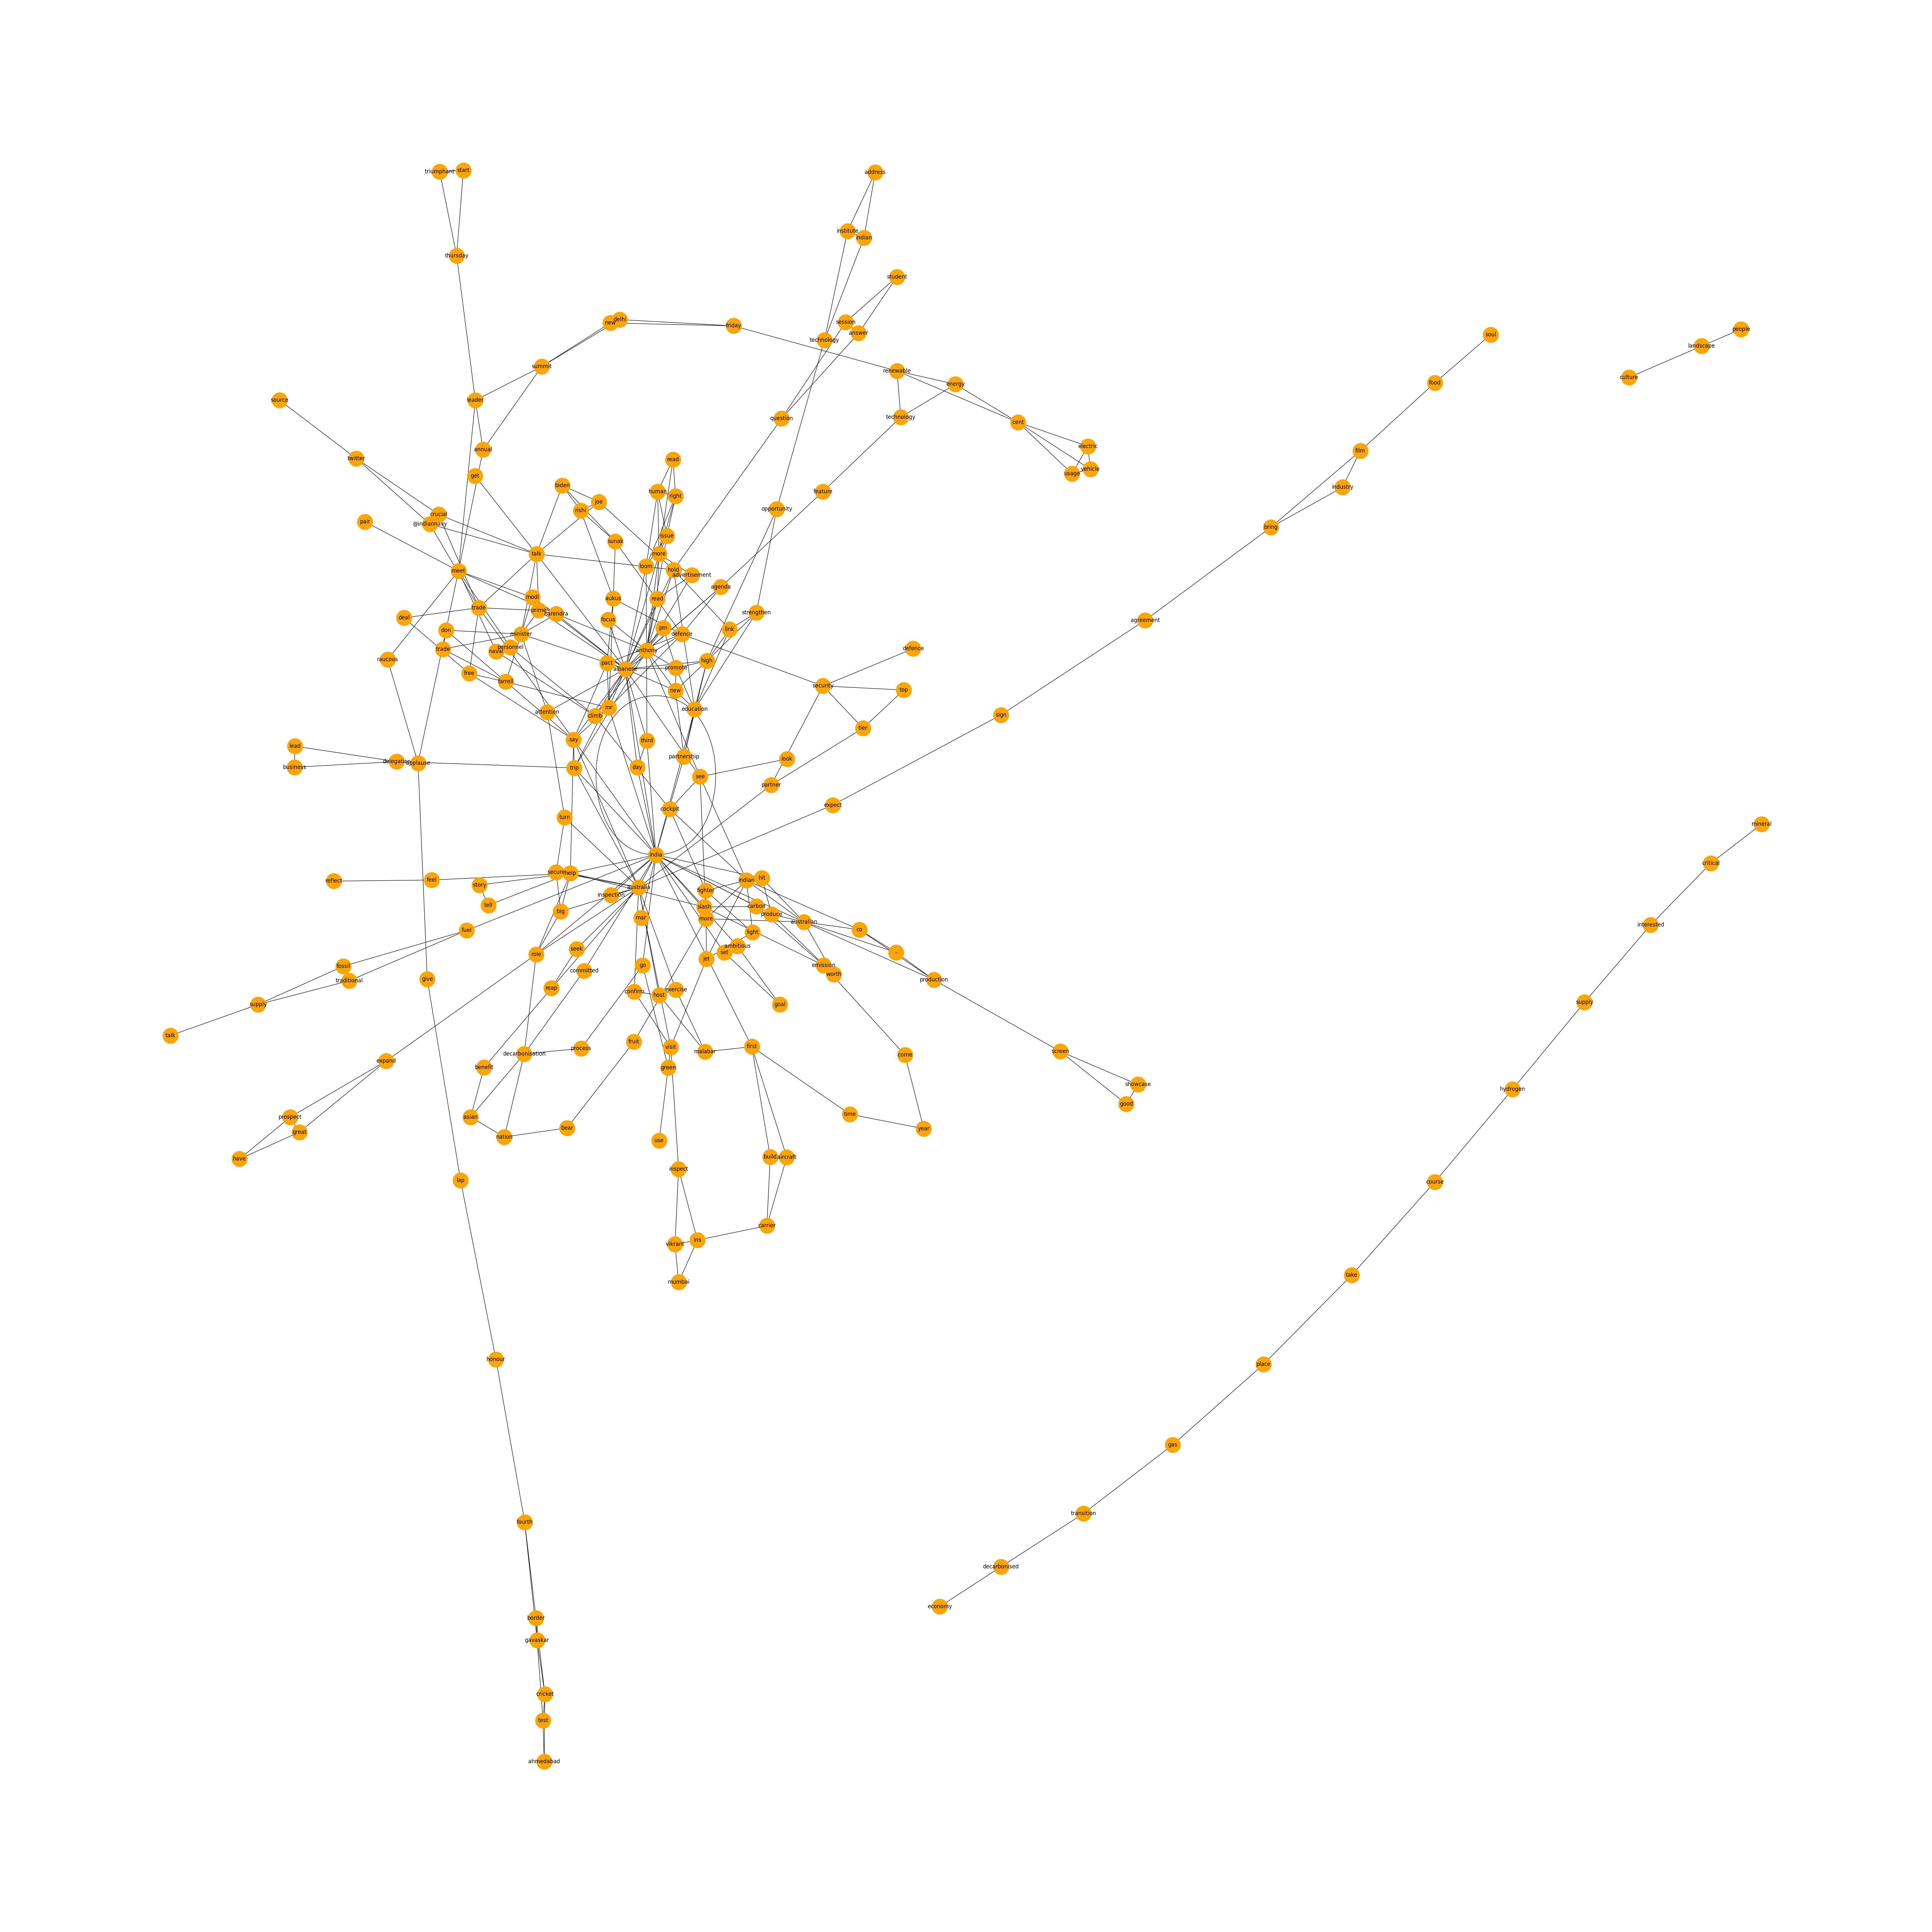

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

plt.rc('font', **font)

fig = plt.figure(figsize=(60, 60))
# plt.savefig('foo.png')
# plt.figure(1)
pos = nx.spring_layout(lemma_graph)
nx.draw(lemma_graph, pos=pos, with_labels=False, font_weight="bold", node_color='orange', node_size=1200)
nx.draw_networkx_labels(lemma_graph, pos, labels)

Now to run the algorithm, we use `PageRank` – which is approximately _eigenvalue centrality_ – to calculate ranks for each of the nodes in the lemma graph.

In [14]:
ranks = nx.pagerank(lemma_graph)
ranks

{0: 0.001941700867870046,
 1: 0.006965375935809587,
 2: 0.003932244460619158,
 3: 0.01864306602338867,
 4: 0.027970913331587254,
 5: 0.005757925857251574,
 6: 0.005101420820091361,
 7: 0.010670136115932278,
 8: 0.006047600351948578,
 9: 0.006398588607756158,
 10: 0.00782665646350573,
 11: 0.00520972465944456,
 12: 0.00520972465944456,
 13: 0.005935088546389685,
 14: 0.005527546418956935,
 15: 0.006415959531692376,
 16: 0.006530432233906537,
 17: 0.007091813745313259,
 18: 0.005420606118348767,
 19: 0.007045853764609293,
 20: 0.006793367869051739,
 21: 0.004420101132208322,
 22: 0.005471712036634236,
 23: 0.002015603174291364,
 24: 0.0044401872077275955,
 25: 0.0046339557925685155,
 26: 0.0046339557925685155,
 27: 0.0068482109238887185,
 28: 0.009437050440228582,
 29: 0.0058580473871163155,
 30: 0.008443782340096975,
 31: 0.0019766256427930806,
 32: 0.003579525418260927,
 33: 0.002907052054600822,
 34: 0.030253203792106158,
 35: 0.02000763607059582,
 36: 0.0027905346807387457,
 37: 0.00

In [15]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    print(node_id, rank, labels[node_id])

34 0.030253203792106158 india
4 0.027970913331587254 albanese
35 0.02000763607059582 australia
3 0.01864306602338867 anthony
100 0.010783968863313911 help
7 0.010670136115932278 meet
75 0.010553636805329036 say
161 0.009902545693253318 education
160 0.009799620533579372 high
155 0.009520696865315773 australian
28 0.009437050440228582 talk
30 0.008443782340096975 minister
159 0.007988440316401363 new
74 0.007927948655117185 mr
10 0.00782665646350573 summit
86 0.007725069040748738 indian
158 0.007442593965683855 promote
185 0.007346499142153525 landscape
17 0.007091813745313259 visit
19 0.007045853764609293 ins
1 0.006965375935809587 security
27 0.0068482109238887185 trade
20 0.006793367869051739 vikrant
41 0.006755521333204633 decarbonisation
99 0.0066822450272406055 role
66 0.0066564197314071165 more
162 0.006619292507956798 partnership
108 0.006607515753302849 cent
169 0.006587020210970625 film
16 0.006530432233906537 jet
48 0.006476208370424921 defence
61 0.00646245555537361 cricket


Define a function to collect the top-ranked phrases from the lemma graph.

In [16]:
import math

def collect_phrases (chunk, phrases, counts):
    chunk_len = chunk.end - chunk.start + 1
    sq_sum_rank = 0.0
    non_lemma = 0
    compound_key = set([])

    for i in range(chunk.start, chunk.end):
        token = doc[i]
        key = (token.lemma_, token.pos_)
        
        if key in seen_lemma:
            node_id = list(seen_lemma.keys()).index(key)
            rank = ranks[node_id]
            sq_sum_rank += rank
            compound_key.add(key)
        
            print(" {} {} {} {}".format(token.lemma_, token.pos_, node_id, rank))
        else:
            non_lemma += 1
    
    # although the noun chunking is greedy, we discount the ranks using a
    # point estimate based on the number of non-lemma tokens within a phrase
    non_lemma_discount = chunk_len / (chunk_len + (2.0 * non_lemma) + 1.0)

    # use root mean square (RMS) to normalize the contributions of all the tokens
    phrase_rank = math.sqrt(sq_sum_rank / (chunk_len + non_lemma))
    phrase_rank *= non_lemma_discount

    # remove spurious punctuation
    phrase = chunk.text.lower().replace("'", "")

    # create a unique key for the the phrase based on its lemma components
    compound_key = tuple(sorted(list(compound_key)))
    
    if not compound_key in phrases:
        phrases[compound_key] = set([ (phrase, phrase_rank) ])
        counts[compound_key] = 1
    else:
        phrases[compound_key].add( (phrase, phrase_rank) )
        counts[compound_key] += 1

    print("{} {} {} {} {} {}".format(phrase_rank, chunk.text, chunk.start, chunk.end, chunk_len, counts[compound_key]))

Collect the top-ranked phrases based on both the noun chunks and the named entities...

In [17]:
phrases = {}
counts = {}

for chunk in doc.noun_chunks:
    collect_phrases(chunk, phrases, counts)

for ent in doc.ents:
    collect_phrases(ent, phrases, counts)

 Defence PROPN 0 0.001941700867870046
0.01101618374219847 
Defence 0 2 3 1
 security NOUN 1 0.006965375935809587
0.03934286871936002 security 3 4 2 1
 agenda NOUN 2 0.003932244460619158
0.015676902716694308 the agenda 6 8 3 1
 Anthony PROPN 3 0.01864306602338867
 Albanese PROPN 4 0.027970913331587254
0.09348861497026248 Anthony Albanese 9 11 3 1
 Narendra PROPN 5 0.005757925857251574
 Modi PROPN 6 0.005101420820091361
0.04512346952531243 Narendra Modi 12 14 3 1
 annual ADJ 8 0.006047600351948578
 leader NOUN 9 0.006398588607756158
 summit NOUN 10 0.00782665646350573
0.02745812806312491 their annual leaders' summit 16 21 6 1
 New PROPN 11 0.00520972465944456
 Delhi PROPN 12 0.00520972465944456
0.0442000763267634 New Delhi 22 24 3 1
 Anthony PROPN 3 0.01864306602338867
 Albanese PROPN 4 0.027970913331587254
0.09348861497026248 Anthony Albanese 25 27 3 2
 cockpit NOUN 14 0.005527546418956935
0.018586867707734094 the cockpit 30 32 3 1
 fighter NOUN 15 0.006415959531692376
 jet NOUN 16 0.00

Since noun chunks can be expressed in different ways (e.g., they may have articles or prepositions), we need to find a minimum span for each phrase based on combinations of lemmas...

In [18]:
import operator

min_phrases = {}

for compound_key, rank_tuples in phrases.items():
    l = list(rank_tuples)
    l.sort(key=operator.itemgetter(1), reverse=True)
    
    phrase, rank = l[0]
    count = counts[compound_key]
    
    min_phrases[phrase] = (rank, count)

Yield the results of TextRank...

In [19]:
for phrase, (rank, count) in sorted(min_phrases.items(), key=lambda x: x[1][0], reverse=True):
    print(phrase, count, rank)

india india 23 0.10651268197749886
anthony albanese 13 0.09348861497026248
more anthony albanese 1 0.09232152432570255
mr albanese 2 0.08204289501539475
albanese 3 0.07884008192620363
new higher education partnership 2 0.0690308898762709
australia 12 0.06667939223644208
higher education links 1 0.06090685319687014
prime minister narendra modi 1 0.059115208144488014
anthony albaneses trip 1 0.05830298080283563
anthony albaneses third day 1 0.05806430853439137
prime minister albaneses attention 1 0.053656412185554454
trade minister don farrell 1 0.053000129307793485
more human rights issues 1 0.052864086302039384
australian produce 1 0.05128919802153233
mr farrell 1 0.050163462430082205
aukus defence pact 1 0.04983135579667148
renewable energy 1 0.04626541359315859
australian 1 0.04599685222397959
talks 2 0.04579434812343981
india 09 mar 1 0.0455640603552961
narendra modi 3 0.04512346952531243
new delhi 4 0.0442000763267634
great prospects 1 0.043113913215740284
indias first domestically

Just for kicks, compare with raw results of the non-chunked lemma nodes...

In [20]:
for node_id, rank in sorted(ranks.items(), key=lambda x: x[1], reverse=True):
    print(labels[node_id], rank)

india 0.030253203792106158
albanese 0.027970913331587254
australia 0.02000763607059582
anthony 0.01864306602338867
help 0.010783968863313911
meet 0.010670136115932278
say 0.010553636805329036
education 0.009902545693253318
high 0.009799620533579372
australian 0.009520696865315773
talk 0.009437050440228582
minister 0.008443782340096975
new 0.007988440316401363
mr 0.007927948655117185
summit 0.00782665646350573
indian 0.007725069040748738
promote 0.007442593965683855
landscape 0.007346499142153525
visit 0.007091813745313259
ins 0.007045853764609293
security 0.006965375935809587
trade 0.0068482109238887185
vikrant 0.006793367869051739
decarbonisation 0.006755521333204633
role 0.0066822450272406055
more 0.0066564197314071165
partnership 0.006619292507956798
cent 0.006607515753302849
film 0.006587020210970625
jet 0.006530432233906537
defence 0.006476208370424921
cricket 0.00646245555537361
gavaskar 0.006436173266623517
first 0.0064315758669972484
fighter 0.006415959531692376
leader 0.006398